This notebook demonstrate the evaluation of inferring latent variables in 4-P RL and HRL models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from utils.feature_utils import (
    get_onehot_features,
    get_feature_list_by_model,
    CognitiveModel,
)

# 4-P RL
## Generate simluated testing data

In [22]:
import tqdm
import random

from simulation.prl.simulate_4prl import simulate_4prl

model_name = CognitiveModel.PRL4
num_agents = 10
num_trials = 500

data_list = []
for a in tqdm.tqdm(range(num_agents)):
    rand_beta = random.uniform(1e-4, 10)
    rand_alpha = random.uniform(1e-4, 1)
    rand_neg_alpha = random.uniform(1e-4, 1)
    rand_stickiness = random.uniform(0, 1)

    parameters = [rand_beta, rand_alpha, rand_neg_alpha, rand_stickiness]
    data = simulate_4prl(parameters, num_trials, 0.8, 15, 2, a)
    data_list.append(data)

data_df = pd.concat(data_list)
data_df.head(3)

100%|██████████| 10/10 [00:00<00:00, 76.85it/s]


,agentid,actions,correct_actions,rewards,isswitch,iscorrectaction,trials,rpe_history,unchosen_rpe_history,alpha,beta,neg_alpha,stickiness
0,0,0,1,0,0,0,0,-0.500000,0.500000,0.392702,3.920581,0.500678,0.225644
1,0,1,1,0,0,1,1,-0.750339,0.750339,0.392702,3.920581,0.500678,0.225644
2,0,1,1,1,0,1,2,0.625339,-0.625339,0.392702,3.920581,0.500678,0.225644


## LaseNet infers latent variables

In [34]:
def lasenet_predict(test_data, trained_model_pth, model_name):
    test_features = get_onehot_features(
        test_data, get_feature_list_by_model(model_name)
    )

    # evaluate ANN
    best_model = tf.keras.models.load_model(trained_model_pth)
    output_tokens = best_model.predict(test_features)
    return output_tokens

In [41]:
trained_model_pth = "results/models/4prl_pretrained"
lasenet_pred = lasenet_predict(data_df, trained_model_pth, model_name)
lasenet_pred = np.squeeze(lasenet_pred, axis=-1)
lasenet_pred.shape

1/1 [==============================] - 0s 411ms/step


(10, 500)

## Infer latent variables with MLE-based method
We demonstrate using python-version of MLE to recover parameters for simplicity. In our work, we run the MATLAB version implementation in `benchmarks` folder.

In [24]:
from benchmarks.get_4prl_latent import fit_4prl_mle

model_specs = {
    'param_names': ['alpha', 'neg_alpha', 'beta', 'stickiness'],
    'bounds': [(1e-4, 1), (1e-4, 1), (1e-4, 1), (0, 1)],
}
actions = data_df['actions'].to_numpy().astype(np.int32).reshape((num_agents, num_trials))
rewards = data_df['rewards'].to_numpy().astype(np.int32).reshape((num_agents, num_trials))
# Recover the parameters first
mle_recovered_parameters = fit_4prl_mle(actions, rewards, model_specs)

evaluating 0...
evaluating 1...
evaluating 2...
evaluating 3...
evaluating 4...
evaluating 5...
evaluating 6...
evaluating 7...
evaluating 8...
evaluating 9...
10


In [25]:
from benchmarks.get_4prl_latent import get_4prl_latent
# infer the latent variables - chosen q values
mle_pred_q = []
for aid in range(actions.shape[0]):
  est_params = mle_recovered_parameters.iloc[aid].to_list()
  _, q_values_history = get_4prl_latent(actions[aid], rewards[aid], est_params)
  mle_pred_q.append(q_values_history)

mle_pred_q = np.array(mle_pred_q)
mle_pred_q.shape

(10, 500)

## Compare LaseNet v.s. MLE-based

/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


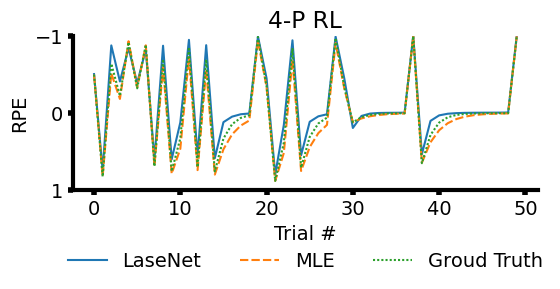

In [43]:
true_label = data_df['rpe_history'].to_numpy().reshape((num_agents, num_trials))

nrows, n_cols = 1, 1
fig, ax = plt.subplots(nrows=nrows, ncols=n_cols, figsize=(n_cols*6, nrows*2), sharey=True, sharex=True)

lasenet_rpe = rewards-lasenet_pred
mle_rpe = rewards-mle_pred_q

max_trial = 50
agent_idx = 5
result = {
    'LaseNet': lasenet_rpe[agent_idx][:max_trial],
    'MLE': mle_rpe[agent_idx][:max_trial],
    'Groud Truth': true_label[agent_idx][:max_trial],
}

plt.rcParams.update({'font.size': 14})
plot_ = sns.lineplot(result, ax=ax, legend=True)
sns.move_legend(
  ax, "lower center",
  bbox_to_anchor=(0.5, -0.64), ncol=len(result), title=None, frameon=False,
)
ax.set_xlabel('Trial #')
ax.set_title('4-P RL')
ax.set(ylim=(1, -1))

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(3)
# increase tick width
ax.tick_params(width=4)
ax.set_ylabel('RPE', color='black')
sns.despine()

# HRL

In [51]:
from simulation.hrl.simulate_hrl import simulate_hrl

# Generate the test data for HRL
model_name = CognitiveModel.HRL2
num_agents = 10
num_trials = 720

data_list = []
for a in tqdm.tqdm(range(num_agents)):
    # simulate N_AGENTS agents with randomly sampled alphas and betas
    rand_alpha = random.uniform(0.4, 0.7)
    rand_beta = random.uniform(1, 10)
    # Fixed stickiness to 0
    parameters = [rand_beta, rand_alpha, 0, 0]
    data = simulate_hrl(parameters, num_trials, [0.1, 0.9], 0.05, 3, a)
    data_list.append(data)

data_df = pd.concat(data_list)
data_df.head(3)

100%|██████████| 10/10 [00:00<00:00, 35.72it/s]


,agentid,correctcue,rewards,isswitch,iscorrectcue,trials,rpe_history,chosen_qv,chosenside,chosencue,correctruleiteration,alpha,stickiness,allstims0,allstims1,allstims2,beta,qv0,qv1,qv2
0,0,1,1,0,1,0,0.666667,0.333333,0,1,0,0.491817,0,1,0,0,4.863711,0.333333,0.333333,0.333333
1,0,1,1,0,1,1,0.338789,0.661211,0,1,1,0.491817,0,0,0,1,4.863711,0.169394,0.661211,0.169394
2,0,1,0,0,0,2,-0.086083,0.086083,1,2,2,0.491817,0,0,0,1,4.863711,0.086083,0.827833,0.086083


In [52]:
# LaseNet infers the latent variables
trained_model_pth = "results/models/hrl_pretrained"
lasenet_pred_cue, lasenet_pred_q = lasenet_predict(data_df, trained_model_pth, model_name)
lasenet_pred_q = np.squeeze(lasenet_pred_q, axis=-1)
print(lasenet_pred_cue.shape, lasenet_pred_q.shape)

1/1 [==============================] - 0s 445ms/step
(10, 720, 3) (10, 720)


## Plot time series and confusion matrix

/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ccnlab/miniconda3/envs/lasenet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


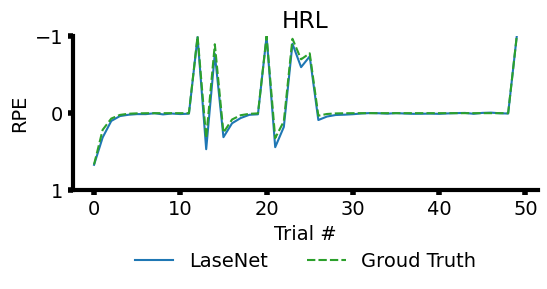

In [63]:
# Evaluate the results

rewards = data_df['rewards'].to_numpy().reshape((num_agents, num_trials))
true_label = data_df['rpe_history'].to_numpy().reshape((num_agents, num_trials))

nrows, n_cols = 1, 1
fig, ax = plt.subplots(nrows=nrows, ncols=n_cols, figsize=(n_cols*6, nrows*2), sharey=True, sharex=True)

lasenet_rpe = rewards-lasenet_pred_q

max_trial = 50
agent_idx = 2
result = {
    'LaseNet': lasenet_rpe[agent_idx][:max_trial],
    'Groud Truth': true_label[agent_idx][:max_trial],
}

plt.rcParams.update({'font.size': 14})
line_color = {'LaseNet': sns.color_palette()[0], 'Groud Truth': sns.color_palette()[2]}
plot_ = sns.lineplot(result, ax=ax, palette=line_color)
sns.move_legend(
  ax, "lower center",
  bbox_to_anchor=(0.5, -0.64), ncol=len(result), title=None, frameon=False,
)
ax.set_xlabel('Trial #')
ax.set_title('HRL')
ax.set(ylim=(1, -1))

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(3)
# increase tick width
ax.tick_params(width=4)
ax.set_ylabel('RPE', color='black')
sns.despine()

#plt.savefig("results/hrl_rpe.png", bbox_inches='tight', dpi=300)

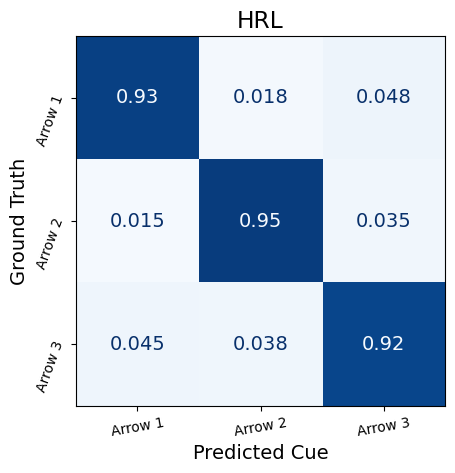

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.rcParams.update({'font.size': 14})
target_names = ['Arrow 1', 'Arrow 2', 'Arrow 3']
true_latent = data_df['chosencue'].to_numpy()
pred_latent = np.argmax(lasenet_pred_cue, axis=2)

disp = ConfusionMatrixDisplay.from_predictions(
    true_latent,
    pred_latent.ravel(),
    display_labels=target_names,
    cmap=plt.cm.Blues,
    #ax=ax,
    colorbar=False,
    normalize='true')
# Set the fixed color bar range
disp.im_.set_clim(0, 1)
disp.ax_.tick_params(axis='both', which='major', labelsize=10)
plt.setp(disp.ax_.get_yticklabels(), rotation=70)
plt.setp(disp.ax_.get_xticklabels(), rotation=10)
disp.ax_.set_xlabel('Predicted Cue')
disp.ax_.set_ylabel('Ground Truth')
disp.ax_.set_title('HRL')
#plt.savefig("results/hrl_cf.png", bbox_inches='tight', dpi=300)